In [34]:
import pandas as pd
import numpy as np
import os
import pathlib
import pickle
import time
from tqdm.notebook import tqdm
import importlib
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torchvision
from torch import nn, optim
from torchvision.transforms import ToTensor, Normalize, Compose
from torch.utils.data import DataLoader, Dataset
from skimage import io, transform
from sklearn.metrics import classification_report, auc, roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split


In [2]:
if torch.cuda.is_available():
        torch.cuda.set_device('cuda:1')

In [3]:
DATASET_PATH = '/home/ilambda/goods_viewer/Debasish/dataset/'
TRAIN_IMAGE_PATH = '/home/ilambda/goods_viewer/Debasish/dataset/1_train_split/whole_resize'
TEST_IMAGE_PATH = '/home/ilambda/goods_viewer/Debasish/dataset/1_eval_img_resize/'
BATCH_SIZE = 32

In [4]:
training_df = pd.read_csv('attributes_training_df.csv', index_col='index')
testing_df = pd.read_csv('attributes_testing_df.csv', index_col='index')

# The list of features
with open('all_features.pickle', 'rb') as f:
    all_features = pickle.load(f)

In [5]:
class ImageFeaturesDataSet(Dataset):
    def __init__(self, df, y_cols, imagedir, x_col='filename', transform=None):
        self.df = df
        self.y_cols = y_cols
        self.imagedir = imagedir
        self.x_col = x_col
        self.df.reset_index(inplace=True, drop=True)
        self.filenames = list(df[x_col].values)
        self.idx = 0
        self.transform = transform
        
    def __getitem__(self, idx):
        im = io.imread(os.path.join(self.imagedir, self.filenames[idx]))
        im = im /255.
        #sample = (im, self.labels[idx])
        if self.transform:
            # to avoid the type mismatch error. ToTensor() expects a float32
            im = im.astype(np.float32)
            im = self.transform(im)
        sample = (im, torch.tensor(self.df.iloc[idx][self.y_cols].values.astype(np.long)).type(torch.float32))
        return sample
    
    def __len__(self):
        return len(self.filenames)

In [7]:
import classification_metrics as metrics
importlib.reload(metrics)

<module 'classification_metrics' from '/home/ilambda/goods_viewer/Debasish/torch/classification_metrics.py'>

In [10]:
means = [0.2,0.2,0.2]
stds = [0.5,0.5,0.5]
train_df, val_df = train_test_split(training_df, test_size=0.25)

training_transforms = Compose([ToTensor(), Normalize(means, stds)])

train_ds = ImageFeaturesDataSet(train_df, all_features, TRAIN_IMAGE_PATH, transform=training_transforms)
train_gen = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

val_ds = ImageFeaturesDataSet(val_df, all_features, TRAIN_IMAGE_PATH, transform=training_transforms)
val_gen = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, drop_last=True)

In [26]:
def validate(args, model, val_gen, bce_loss):
    results = {}
    model.eval()
    all_preds = []
    all_labels = []
    tps, tns, fps, fns = torch.tensor(0), torch.tensor(0), torch.tensor(0), torch.tensor(0)
    val_loss = 0.0
    for images, labels in val_gen:
        if torch.cuda.is_available():
            images = images.cuda()
            labels = labels.cuda()
        outputs = model(images)
        outputs = nn.Sigmoid()(outputs)
        loss = bce_loss(outputs, labels)
        val_loss += loss.cpu().item() * labels.size(0)
        preds = outputs.cpu().data.apply_(lambda x: 1 if x >= 0.5 else 0)
        all_labels.append(labels.detach().cpu())
        all_preds.append(outputs.detach().cpu())
        tp, tn, fp, fn = metrics.classifications(labels.cpu(), preds)
        tps += tp
        tns += tn
        fps += fp
        fns += fn
    val_auc = roc_auc_score(torch.cat(all_labels).flatten(), torch.cat(all_preds).flatten())
    val_loss = val_loss / (len(val_gen) * BATCH_SIZE)
    prec = metrics.precision(tps, tns, fps, fns)
    rec = metrics.recall(tps, tns, fps, fns)
    f1 = metrics.calculate_f1(prec, rec)
    results['val_loss'] = val_loss
    results['val_tps'] = tps.cpu().item()
    results['val_tns'] = tns.cpu().item()
    results['val_fps'] = fps.cpu().item()
    results['val_fns'] = fns.cpu().item()
    results['val_precision'] = prec
    results['val_recall'] = rec
    results['val_f1'] = f1
    results['val_auc'] = val_auc
    
    return results

def train(args, model, training_gen, val_gen, adam, bce_loss):
    
    history = {'loss': [], 'tp': [], 'tn': [], 'fp': [], 'fn': [], 'precision': [], 'recall': [], 'f1': [], 'auc': [],
              'val_loss': [], 'val_tp': [], 'val_tn': [], 'val_fp': [], 'val_fn': [], 'val_precision': [], 'val_recall': [], 'val_f1': [], 'val_auc': []}
    
    
    if torch.cuda.is_available():
        torch.cuda.set_device('cuda:1')
        model.cuda()
    epochs = args['epochs']
    
    for epoch in range(epochs):
        #print(f"epoch: {epoch+1} started...")
        start = time.time()
        model.train()
        train_loss = 0.0 
        all_labels, all_preds = [], []
        tps, tns, fps, fns = torch.tensor(0), torch.tensor(0), torch.tensor(0), torch.tensor(0)
        for batch, (images, labels) in tqdm(enumerate(training_gen),desc=f'epoch: {epoch+1} ', total=len(training_gen)):
            if torch.cuda.is_available():
                images = images.cuda()
                labels = labels.cuda()
            adam.zero_grad()
            outputs = model(images)
            outputs = nn.Sigmoid()(outputs)
            preds = outputs.cpu().data.apply_(lambda x: 1 if x >= 0.5 else 0)
            loss = bce_loss(outputs, labels)
            train_loss += loss.cpu().item() * labels.size(0)
            loss.backward()
            adam.step()
            tp, tn, fp, fn = metrics.classifications(labels.cpu(), preds)
            tps += tp
            tns += tn
            fps += fp
            fns += fn
            all_preds.append(outputs.detach().cpu())
            all_labels.append(labels.detach().cpu())
        train_auc = roc_auc_score(torch.cat(all_labels).flatten(), torch.cat(all_preds).flatten())
        prec = metrics.precision(tps, tns, fps, fns)
        rec = metrics.recall(tps, tns, fps, fns)
        f1 = metrics.calculate_f1(prec, rec)
        with torch.no_grad():
            val_results = validate(args, model, val_gen, bce_loss)
        end = time.time()
        duration = (end - start)/60
        train_loss = train_loss / (len(training_gen) * BATCH_SIZE)   
        print(f"epoch: {epoch+1}, duration: {duration: 0.2f} mins")
        print(f"loss: {train_loss: 0.4f}, precision: {prec: 0.4f}, recall: {rec: 0.4f}, f1: {f1: 0.4f}, auc: {train_auc: 0.4f}") 
        print(f"val_loss: {val_results['val_loss']: 0.4f}, val_precision: {val_results['val_precision']: 0.4f}, val_recall: {val_results['val_recall']: 0.4f}, val_f1: {val_results['val_f1']: 0.4f}, val_auc: {val_results['val_auc']: 0.4f}")
        history['loss'].append(train_loss)
        history['tp'].append(tps.cpu().item())
        history['tn'].append(tns.cpu().item())
        history['fp'].append(fps.cpu().item())
        history['fn'].append(fns.cpu().item())
        history['precision'].append(prec)
        history['recall'].append(rec)
        history['f1'].append(f1)
        history['auc'].append(train_auc)
        history['val_loss'].append(val_results['val_loss'])
        history['val_tp'].append(val_results['val_tps'])
        history['val_tn'].append(val_results['val_tns'])
        history['val_fp'].append(val_results['val_fps'])
        history['val_fn'].append(val_results['val_fns'])
        history['val_precision'].append(val_results['val_precision'])
        history['val_recall'].append(val_results['val_recall'])
        history['val_f1'].append(val_results['val_f1'])
        history['val_auc'].append(val_results['val_auc'])
        
    torch.save(model, 'feature_detection_model1.pickle')
    return history

### Dense only train model

In [12]:
args = {'epochs': 10, 'lr': 0.00001}

In [14]:
resnet = torchvision.models.resnet50(pretrained=True, progress=False)
resnet.fc = nn.Linear(in_features=resnet.fc.in_features, out_features=len(all_features))

In [16]:
for name,c in resnet.named_children():
    #print(name)
    for p in c.parameters():
        if name != 'fc':
            p.requires_grad = False

conv1
bn1
relu
maxpool
layer1
layer2
layer3
layer4
avgpool
fc


In [24]:
for name,c in resnet.named_children():
    #print(name)
    for p in c.parameters():
            print(name,p.requires_grad)

conv1 False
bn1 False
bn1 False
layer1 False
layer1 False
layer1 False
layer1 False
layer1 False
layer1 False
layer1 False
layer1 False
layer1 False
layer1 False
layer1 False
layer1 False
layer1 False
layer1 False
layer1 False
layer1 False
layer1 False
layer1 False
layer1 False
layer1 False
layer1 False
layer1 False
layer1 False
layer1 False
layer1 False
layer1 False
layer1 False
layer1 False
layer1 False
layer1 False
layer2 False
layer2 False
layer2 False
layer2 False
layer2 False
layer2 False
layer2 False
layer2 False
layer2 False
layer2 False
layer2 False
layer2 False
layer2 False
layer2 False
layer2 False
layer2 False
layer2 False
layer2 False
layer2 False
layer2 False
layer2 False
layer2 False
layer2 False
layer2 False
layer2 False
layer2 False
layer2 False
layer2 False
layer2 False
layer2 False
layer2 False
layer2 False
layer2 False
layer2 False
layer2 False
layer2 False
layer2 False
layer2 False
layer2 False
layer3 False
layer3 False
layer3 False
layer3 False
layer3 False
layer3

In [21]:
adam = torch.optim.Adam(list(filter(lambda p: p.requires_grad, resnet.parameters())),lr=args['lr'])
bce_loss = torch.nn.BCELoss()

In [27]:
history = train(args, resnet, train_gen, val_gen, adam, bce_loss)


epoch: 1, duration:  7.46 mins
loss:  0.1194, precision:  0.7022, recall:  0.2234, f1:  0.3390, auc:  0.9131
val_loss:  0.1166, val_precision:  0.6968, val_recall:  0.2526, val_f1:  0.3708, val_auc:  0.9184



epoch: 2, duration:  7.40 mins
loss:  0.1152, precision:  0.7033, recall:  0.2535, f1:  0.3727, auc:  0.9219
val_loss:  0.1133, val_precision:  0.6957, val_recall:  0.2750, val_f1:  0.3942, val_auc:  0.9253



epoch: 3, duration:  7.49 mins
loss:  0.1125, precision:  0.7007, recall:  0.2743, f1:  0.3943, auc:  0.9274
val_loss:  0.1112, val_precision:  0.7008, val_recall:  0.2839, val_f1:  0.4041, val_auc:  0.9296



epoch: 4, duration:  7.50 mins
loss:  0.1106, precision:  0.6983, recall:  0.2895, f1:  0.4093, auc:  0.9313
val_loss:  0.1095, val_precision:  0.6984, val_recall:  0.2934, val_f1:  0.4132, val_auc:  0.9330



epoch: 5, duration:  7.48 mins
loss:  0.1092, precision:  0.6956, recall:  0.3002, f1:  0.4194, auc:  0.9340
val_loss:  0.1083, val_precision:  0.6990, val_recall:  0.3023, val_f1:  0.4220, val_auc:  0.9353



epoch: 6, duration:  7.43 mins
loss:  0.1081, precision:  0.6950, recall:  0.3090, f1:  0.4278, auc:  0.9362
val_loss:  0.1073, val_precision:  0.6892, val_recall:  0.3204, val_f1:  0.4375, val_auc:  0.9371



epoch: 7, duration:  7.47 mins
loss:  0.1072, precision:  0.6932, recall:  0.3161, f1:  0.4342, auc:  0.9378
val_loss:  0.1064, val_precision:  0.6923, val_recall:  0.3235, val_f1:  0.4409, val_auc:  0.9388



epoch: 8, duration:  7.39 mins
loss:  0.1064, precision:  0.6926, recall:  0.3219, f1:  0.4396, auc:  0.9392
val_loss:  0.1057, val_precision:  0.6897, val_recall:  0.3315, val_f1:  0.4477, val_auc:  0.9400



epoch: 9, duration:  7.44 mins
loss:  0.1058, precision:  0.6922, recall:  0.3265, f1:  0.4437, auc:  0.9402
val_loss:  0.1054, val_precision:  0.6887, val_recall:  0.3358, val_f1:  0.4515, val_auc:  0.9406



epoch: 10, duration:  7.48 mins
loss:  0.1053, precision:  0.6912, recall:  0.3305, f1:  0.4472, auc:  0.9412
val_loss:  0.1048, val_precision:  0.6911, val_recall:  0.3354, val_f1:  0.4516, val_auc:  0.9414


In [28]:
with open('history_1_dense_only.pickle', 'wb') as f:
    pickle.dump(history, f)
torch.save(resnet, 'model_1_dense_only.pickle')

In [29]:
def evaluate(model, test_gen):
    all_preds = []
    all_labels = []
    model.eval()
    if torch.cuda.is_available():
        model.cuda()
    with torch.no_grad():
        for images, labels in tqdm(test_gen, total=len(test_gen)):
            if torch.cuda.is_available():
                images = images.cuda()
                labels = labels.cuda()

            outputs = model(images)
            outputs = nn.Sigmoid()(outputs)
            all_labels.append(labels.cpu())
            all_preds.append(outputs.cpu())
    return all_labels, all_preds

In [30]:
test_ds = ImageFeaturesDataSet(testing_df, all_features, TEST_IMAGE_PATH, transform=training_transforms)
test_gen = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, drop_last=True)

In [31]:
all_labels, all_preds = evaluate(resnet, test_gen)

In [32]:
pres, res = metrics.calc_pres_recall(torch.cat(all_labels), torch.cat(all_preds))

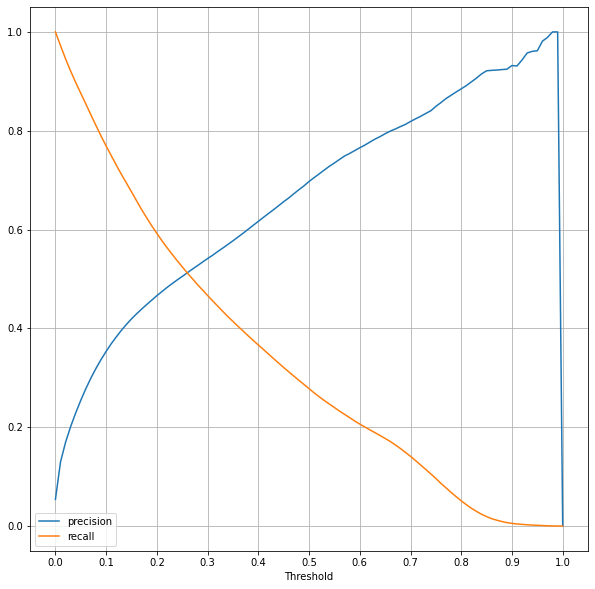

In [37]:
plt.figure(figsize=(10,10))
plt.plot(pres, label='precision')
plt.plot(res, label='recall')
plt.legend()
plt.grid()
plt.xlabel("Threshold")
plt.xticks([i for i in range(0,101,10)], labels=[i/100 for i in range(0,101,10)])
plt.show()

### Dense only with 2 dense layers

In [38]:
from collections import OrderedDict
resnet = torchvision.models.resnet50(pretrained=True, progress=False)
resnet.fc = nn.Linear(in_features=resnet.fc.in_features, out_features=500)
fc1 = nn.Linear(500, len(all_features))
relu1 = nn.ReLU()

modules_dict = {"resnet": resnet, "relu1": relu1, "fc1": fc1}
model = nn.Sequential(OrderedDict(modules_dict))

In [43]:
[name for name,_ in model.named_modules()]

['',
 'resnet',
 'resnet.conv1',
 'resnet.bn1',
 'resnet.relu',
 'resnet.maxpool',
 'resnet.layer1',
 'resnet.layer1.0',
 'resnet.layer1.0.conv1',
 'resnet.layer1.0.bn1',
 'resnet.layer1.0.conv2',
 'resnet.layer1.0.bn2',
 'resnet.layer1.0.conv3',
 'resnet.layer1.0.bn3',
 'resnet.layer1.0.relu',
 'resnet.layer1.0.downsample',
 'resnet.layer1.0.downsample.0',
 'resnet.layer1.0.downsample.1',
 'resnet.layer1.1',
 'resnet.layer1.1.conv1',
 'resnet.layer1.1.bn1',
 'resnet.layer1.1.conv2',
 'resnet.layer1.1.bn2',
 'resnet.layer1.1.conv3',
 'resnet.layer1.1.bn3',
 'resnet.layer1.1.relu',
 'resnet.layer1.2',
 'resnet.layer1.2.conv1',
 'resnet.layer1.2.bn1',
 'resnet.layer1.2.conv2',
 'resnet.layer1.2.bn2',
 'resnet.layer1.2.conv3',
 'resnet.layer1.2.bn3',
 'resnet.layer1.2.relu',
 'resnet.layer2',
 'resnet.layer2.0',
 'resnet.layer2.0.conv1',
 'resnet.layer2.0.bn1',
 'resnet.layer2.0.conv2',
 'resnet.layer2.0.bn2',
 'resnet.layer2.0.conv3',
 'resnet.layer2.0.bn3',
 'resnet.layer2.0.relu',
 're

In [49]:
for name, p in list(model.named_parameters()):
    print(name, p.requires_grad)

resnet.conv1.weight False
resnet.bn1.weight False
resnet.bn1.bias False
resnet.layer1.0.conv1.weight False
resnet.layer1.0.bn1.weight False
resnet.layer1.0.bn1.bias False
resnet.layer1.0.conv2.weight False
resnet.layer1.0.bn2.weight False
resnet.layer1.0.bn2.bias False
resnet.layer1.0.conv3.weight False
resnet.layer1.0.bn3.weight False
resnet.layer1.0.bn3.bias False
resnet.layer1.0.downsample.0.weight False
resnet.layer1.0.downsample.1.weight False
resnet.layer1.0.downsample.1.bias False
resnet.layer1.1.conv1.weight False
resnet.layer1.1.bn1.weight False
resnet.layer1.1.bn1.bias False
resnet.layer1.1.conv2.weight False
resnet.layer1.1.bn2.weight False
resnet.layer1.1.bn2.bias False
resnet.layer1.1.conv3.weight False
resnet.layer1.1.bn3.weight False
resnet.layer1.1.bn3.bias False
resnet.layer1.2.conv1.weight False
resnet.layer1.2.bn1.weight False
resnet.layer1.2.bn1.bias False
resnet.layer1.2.conv2.weight False
resnet.layer1.2.bn2.weight False
resnet.layer1.2.bn2.bias False
resnet.layer

In [50]:
adam = torch.optim.Adam(list(filter(lambda p: p.requires_grad, model.parameters())),lr=args['lr'])
bce_loss = torch.nn.BCELoss()

In [ ]:
history_1 = train(args, model, train_gen, val_gen, adam, bce_loss)